### Problem Statement

In [2]:
#![daimler-mercedes_image.jpg](attachm+ent:daimler-mercedes_image.jpg)

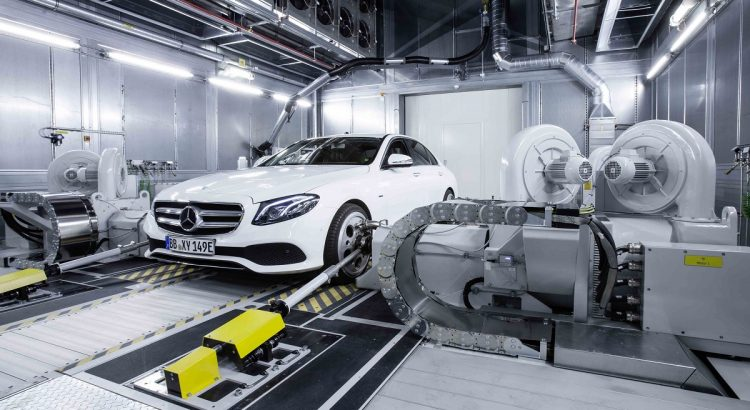

image source : https://www.rad-ab.com/2016/12/23/mercedes-benz-auf-dem-pruefstand/ (glimpse of Benz testing rooms)

<u><b>Abstract</b></u>

Mercedes Benz is Manufacturer of premium cars. Daimler’s Mercedes-Benz is the
European leader among the premium car makers. This has been possible with quality
Research, Engineering , Manufacturing and Testing. They also provide a variety of
features for customers to customize their Mercedes-Benz. Now all these cars have to
be tested for functionality of equipment within the car. They also have to meet quality
standards and safety to achieve best performance when they hit the road. This requires
the testing line within the factory to be versatile to handle every unique car. To tackle
testing of a variety of cars, Company Engineers have built a robust testing system which
can handle every unique configuration of the car. Testing line has to function efficiently
as more the time the car spends on the testing, the more it contributes towards carbon
emissions. Optimizing speed of testing keeps the production line eco-friendly. It is quite
a challenge for company to optimize the speed of its testing system for so many
possible feature combinations. It is complex and time-consuming without a smart
numerical method. Being world’s biggest manufacturers of cars, it is crucial to have a
production line which is efficient and has control over their greenhouse gas emissions.

<u><b>Business problem</b></u>

Company need to keep their production time in check as it reduces their carbon
emissions. Car testing time is of prime interest as it has an impact on company's carbon
footprint. Thus controlling it makes way for greener manufacturing. To help improve the
testing system speed, it is important to understand how the car configuration affects the
process time and to what extent.

When it comes to a systematic approach for such a problem, Company wants to explore
state of the art techniques such as Machine Learning which can provide insight into the
impact of car configuration on testing time. Predicted time will help organize testing of
cars. Thus the best model will help speed up testing of cars while not affecting the
company standards. Thus the Business problem we have at hand is to predict the time
a car takes to pass testing for a given configuration. Hence there has been a kaggle
competition hosted by the company to tackle the problem, which can be found in the link
- https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/overview.

Note on competition leaderboard:

Public leaderboard is calculated with approximately 19% of the test data.
Private leaderboard is calculated with remaining 81% of the test data.

<u><b>ML formulation of the business problem</b></u>

Company provides information of testing time of multiple cars with their particular
configuration. With this data, we have to train a Machine Learning model which has to
predict the Real valued output of car testing time for given labelled features which
represents a set of car configurations. Model’s performance has to be measured using
coefficient of determination (R^2 value). Model should be interpretable, so that which
feature impacts the testing time can be extracted.

<u><b>Business constraints</b></u>

- To predict testing time spent on a car with a high R^2 value.
- No strict latency constraints.

<u><b> Performance metric </b></u> 

Performance metric :
The metric considered to evaluate the models in the competition is R^2.

Other metrics which can be taken up are Mean Square Error/Mean Absolute
Error/Mean Absolute Percentage error.

<u><b>Data set column analysis</b></u>

Following files are provided for analysis
- train.csv
- test.csv
- sample_submission.csv

train.csv file consists of 4209 rows, 378 columns. Each row represents a car and
columns represent its configuration and time. Configurations are encoded as categories
under labels, where one feature has label ID and other features have ‘X’ followed by a
number as label. The ground truth is labeled ‘y’ and represents the time (in seconds)
that the car took to pass testing with specific features configuration.

test.csv consists of data of size (4209,377) having columns ID and Features X0 to
X385. The time is not provided in this file. Our trained model has to predict time for the
configuration in test.csv. This will be used to evaluate the model by the company to put
the best one in the leaderboard. This data cannot be used to improve our performance
as y data is not available for us.

sample_submission.csv captures the format in which the test data predictions to be
submitted for the competition.

Now we have to make use of 4209 rows alone(train.csv) to train and validate. The data
size we have is small. The best way we have to get good model performance is to do
k-fold cross validation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import category_encoders as ce
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings( "ignore")#, module = "matplotlib\*" )

### Loading Data from .csv file

data source : https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data

In [3]:
car_data = pd.read_csv('train.csv')

In [4]:
car_data

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


In [11]:
car_data_test = pd.read_csv('test.csv')

In [17]:
t1 = list(car_data.ID.to_numpy())

In [18]:
t2 = list(car_data_test.ID.to_numpy())

In [19]:
for i in t2:
    t1.append(i)

In [22]:
t3 = list(set(t1))

In [25]:
len(t3),car_data.shape[0]+car_data_test.shape[0]

(8418, 8418)

In [9]:
car_data.iloc[[1621,2173,2366],:10]#1621,2173,2366

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8
1621,3250,89.62,ac,t,av,c,d,ad,a,l
2173,4346,110.75,g,c,au,c,d,k,j,n
2366,4742,112.30,ab,w,av,c,d,n,i,y


In [48]:
car_data[car_data.T.duplicated()]
# dup = car_data.T.duplicated()
# dup.index
# car_data.T[dup]
# dup[dup==True].index

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

##### The data captures the details of 4209 car configuration with their testing time in column 'y'

#### Datatypes of the features

We will check the data types of the information available in the data given to us.

In [61]:
car_data.dtypes.value_counts()

int64      369
object       8
float64      1
dtype: int64

In [8]:
car_data.dtypes[car_data.dtypes == 'object']

X0    object
X1    object
X2    object
X3    object
X4    object
X5    object
X6    object
X8    object
dtype: object

In [9]:
car_data.dtypes[car_data.dtypes == 'float64']

y    float64
dtype: object

In [10]:
car_data.dtypes[car_data.dtypes == 'int64']

ID      int64
X10     int64
X11     int64
X12     int64
X13     int64
        ...  
X380    int64
X382    int64
X383    int64
X384    int64
X385    int64
Length: 369, dtype: object

#### Let us check unique values counts of all features

In [11]:
feat_dict = {'features' : car_data.columns,
             'uniq_count' : []}

In [12]:
for feat in car_data.columns:
    feat_dict['uniq_count'].append(len(car_data[feat].unique()))

In [13]:
feat_dict_df = pd.DataFrame(feat_dict)
feat_dict_df

,features,uniq_count
0,ID,4209
1,y,2545
2,X0,47
3,X1,27
4,X2,44
...,...,...
373,X380,2
374,X382,2
375,X383,2
376,X384,2


We will check how many features have same unique value counts  

In [14]:
feat_dict_df['uniq_count'].value_counts()

2       356
1        12
2545      1
4209      1
47        1
44        1
29        1
27        1
25        1
12        1
7         1
4         1
Name: uniq_count, dtype: int64

Features with only one value across all rows

In [15]:
feat_dict_df[feat_dict_df['uniq_count']==1]['features']

11      X11
91      X93
105    X107
227    X233
229    X235
262    X268
283    X289
284    X290
287    X293
291    X297
323    X330
340    X347
Name: features, dtype: object

Features with two unique values

In [16]:
feat_dict_df[feat_dict_df['uniq_count']==2]['features']

10      X10
12      X12
13      X13
14      X14
15      X15
       ... 
373    X380
374    X382
375    X383
376    X384
377    X385
Name: features, Length: 356, dtype: object

In [17]:
car_data['X10'].unique()

array([0, 1], dtype=int64)

So we observe that one of feature with 2 unique values have 0 or 1 

we will check if all the features with 2 unique values are similar 

In [18]:
Two_val_feat = feat_dict_df[feat_dict_df['uniq_count']==2]['features']
Binary_count=0
nonBinary_count=0
for feat in Two_val_feat:
    for i in car_data[feat].unique(): 
        if (i==0 or i ==1): #order of the unique value is not consistent across features 
            Binary_count+=1 #hence condition to check for both values
        else:
            nonBinary_count+=1
print('Binary_count:', Binary_count/2)
print('nonBinary_count:', nonBinary_count/2)

Binary_count: 356.0
nonBinary_count: 0.0


Thus we can confirm that all 356 features with 2 unique values have binary values 0 and 1

Observations :

Column description of given data -

ID - It is unique for each row - Type: integer

y - It captures the testing time - Type: float

X0,X1,X2,X3,X4,X5,X6 and X8 are of Type: object. These features are categorical.

X10 to X385 - are 368 features which are of type integers.
12 out of 368 Features are of single value and are equal to zero. Identified features are
listed : X11,X93,X107,X233,X235,X268,X289,X290,X293,X297,X330,X347

Remaining 356 features are of binary which takes up value of 0 or 1


#### Check for duplicate rows

In [19]:
car_data[car_data.duplicated()]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385


Data do not contain any duplicates rows. Thus we have unique rows in the data

### EDA

##### We have y as the dependent feature. We will now study how y value depends on individual feature

We will start by looking into Target variable y alone which is a continuous value capturing time required for testing the car. 

Let us see distribution plot to understand what value the y takes up 

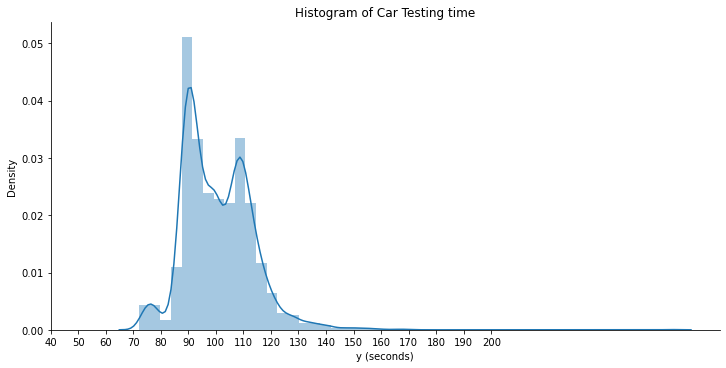

In [20]:
sb.FacetGrid(data=car_data, size=5, height = 3, aspect=2 )\
            .map(sb.distplot,"y")\
            .set(xticks=[40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
plt.title('Histogram of Car Testing time')
plt.xlabel('y (seconds)')
plt.ylabel('Density')
plt.show()

In [21]:
car_data.y.describe()

count    4209.000000
mean      100.669318
std        12.679381
min        72.110000
25%        90.820000
50%        99.150000
75%       109.010000
max       265.320000
Name: y, dtype: float64

We can observe that distribution is not normal. We can observe there are mulptiple peaks in density. 
- mean value distribution is around 100sec
- There are peaks around 90 and 110sec
- Min value is 72 sec
- Max value is 265 sec

#### Feature ID 

We know that ID feature is a collection of unique integers. So we will check scater plot of y vs ID

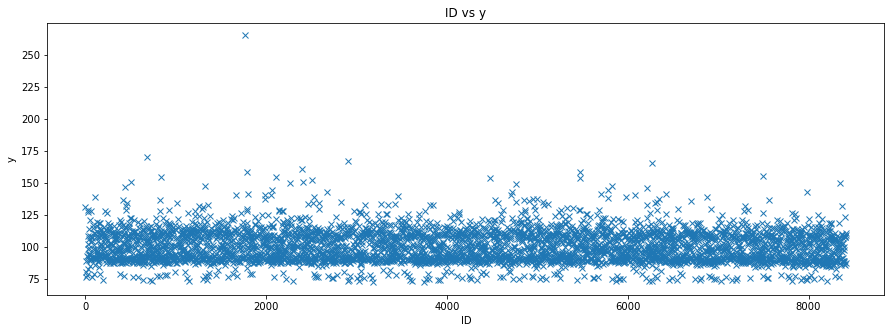

In [22]:
plt.figure(figsize = (15,5))
plt.plot(car_data['ID'],car_data['y'],'x')
plt.title('ID vs y')
plt.xlabel('ID')
plt.ylabel('y')
plt.show()

Here we observe that with increase in IDs value donot impact the value of y. 
It looks like contant value added with some noise added to it.
Majority of IDs have y value scattered in range [75,125]

We will have a look at correlation between ID and y

In [23]:
car_data[['ID','y']].corr('pearson')

,ID,y
ID,1.000000,-0.055108
y,-0.055108,1.000000


The correlation value is very low (close to zero). Thus Feature ID will not be useful in predicting the value of y 

From the above plot we can notice that there are outliers in the distribution.

#### Feature X0

Feautre X0 is categorical feature. categories are listed below

In [24]:
car_data['X0'].unique()

array(['k', 'az', 't', 'al', 'o', 'w', 'j', 'h', 's', 'n', 'ay', 'f', 'x',
       'y', 'aj', 'ak', 'am', 'z', 'q', 'at', 'ap', 'v', 'af', 'a', 'e',
       'ai', 'd', 'aq', 'c', 'aa', 'ba', 'as', 'i', 'r', 'b', 'ax', 'bc',
       'u', 'ad', 'au', 'm', 'l', 'aw', 'ao', 'ac', 'g', 'ab'],
      dtype=object)

In [25]:
len(car_data['X0'].unique())

47

X0 has 47 unique categories. Categories are set of letters and letter combination

We will check how one category(say X0 = 'a') impacts value of y 

In [26]:
car_data[car_data['X0']=='a']['y'].describe()

count     21.000000
mean     115.630952
std        7.924191
min      108.410000
25%      110.100000
50%      113.800000
75%      120.120000
max      142.710000
Name: y, dtype: float64

we observe that category 'a' of X0 feature has distribution of its own for value of y

So to understand how this feature impacts the y value, we need to see how y value varies with each category under the feature. 
We will plot the histogram plot of y for each catogory under the feature X0.

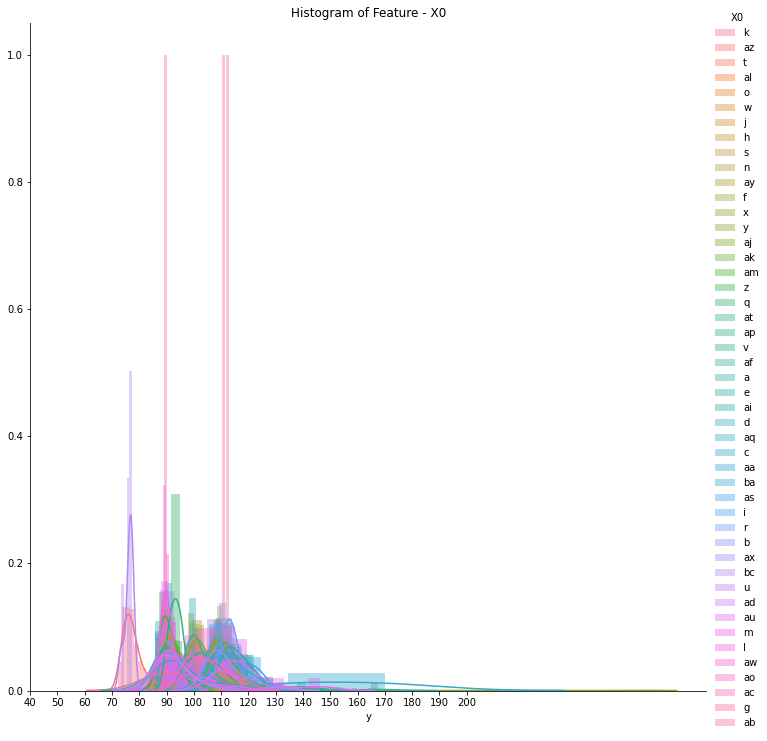

In [27]:
sb.FacetGrid(data=car_data,hue='X0',size=10)\
            .map(sb.distplot,"y").add_legend() \
            .set(xticks=[40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200])
plt.title('Histogram of Feature - X0')
plt.xlabel('y')
plt.show()

We see Histogram plots are not so helpful as there are lot of overlaps due number of categories.

Other Plots which help us visualize the impacts of categorical feature on a continuous variable is boxplot and violin plot. With boxplot we can see percentile value of distribution of y for each category, while with violin plot we can see the density distribution. We will plot both and see how feature X0 impacts y

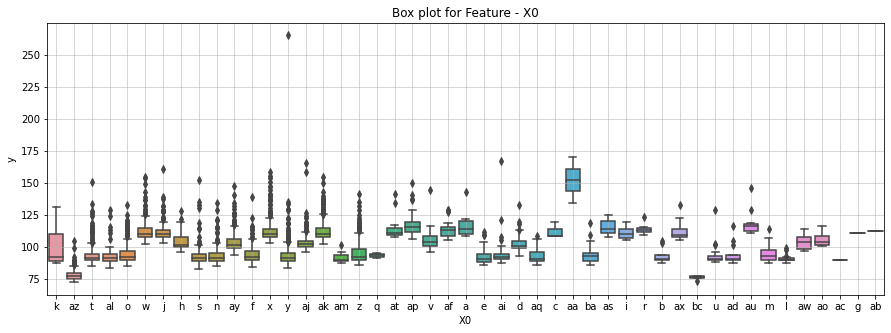

In [28]:
plt.figure(figsize = (15,5))
sb.boxplot(x='X0', y = 'y', data=car_data)
plt.title('Box plot for Feature - X0')
plt.grid(linewidth = 0.5)
plt.show()

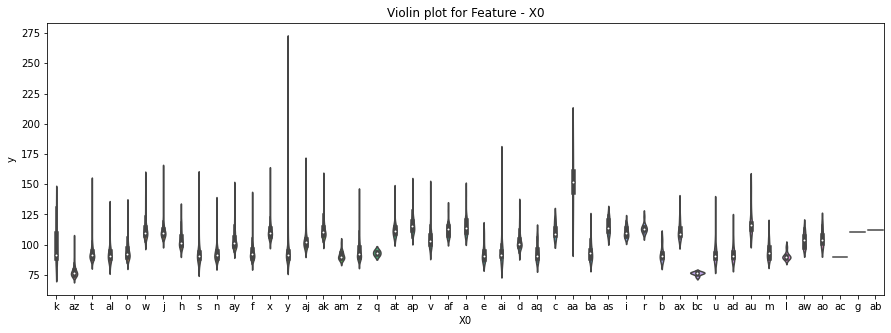

In [29]:
plt.figure(figsize = (15,5))
sb.violinplot(x='X0', y = 'y', data=car_data)
plt.title('Violin plot for Feature - X0')
plt.show()

We can see from both plots, that each category under the Feature X0 have different distribution of target value.

We see that there are lot of outliers when we consider this feature.

One of the observation from the box plot is that for category 'aa', the target value has distribution unique when compared to all other categories meaning it doesnt have overlapping distributions while other categories have some overlap.

Most of the categories have their majority population under y=125 but category 'aa' has y value above it. let us check the violin plot for this particular category

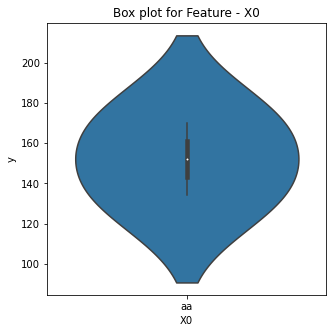

In [30]:
plt.figure(figsize = (5,5))
sb.violinplot(x='X0', y = 'y', data=car_data[car_data['X0']=='aa'])
plt.title('Box plot for Feature - X0')
plt.show()

We can see the distribution of category 'aa' is uniform with mean around 150 seconds.
Thus we can expect the car with feature X0 = 'aa' will have testing time in range ~[100,200]

In addition to above we have categories 'ac','ab' and 'g' which do not have distributions. These categories have single y values which are printed below.

In [31]:
car_data[(car_data['X0']=='ac') | (car_data['X0']=='ab') | (car_data['X0']=='g')][['X0','y']]

,X0,y
1621,ac,89.62
2173,g,110.75
2366,ab,112.30


We will check counts of each category under the feature using bar plots to understand how many rows of data have particular category. 

This will help us understand if the feature has only one category for majority of the class (say >95% of data). 
Feature having one dominant category will not be useful feature as there are no variation in the feature. It would be a constant feature while target variable is varying.

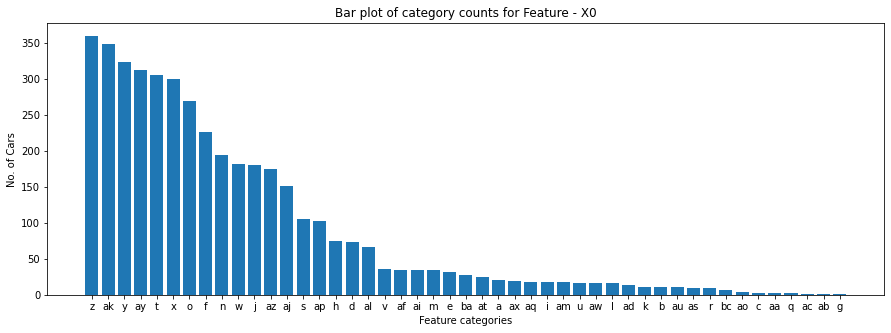

In [32]:
plt.figure(figsize = (15,5))
plt.bar(car_data['X0'].value_counts().index,car_data['X0'].value_counts())
plt.title('Bar plot of category counts for Feature - X0')
plt.xlabel('Feature categories')
plt.ylabel('No. of Cars')
plt.show()

From bar plot we observe that only 18 categories under this feature which have car count above 50.

From above plots we can see that feature 'X0' is will be useful in predicting the target value.  

Note: Box plot and Bar plots are visually informative compared to Violin and histogram plots. So we shall use boxplots and Bar plots to study the categorical features. We will consider violin and histogram plots when needed

Similar to 'X0' feature we will check other catogorical feature with box plots

#### Feature X1

Feautre X1 is categorical feature. categories are listed below

In [33]:
car_data['X1'].unique()

array(['v', 't', 'w', 'b', 'r', 'l', 's', 'aa', 'c', 'a', 'e', 'h', 'z',
       'j', 'o', 'u', 'p', 'n', 'i', 'y', 'd', 'f', 'm', 'k', 'g', 'q',
       'ab'], dtype=object)

In [34]:
len(car_data['X1'].unique())

27

X1 has 27 unique categories. Categories are set of letters and letter combination

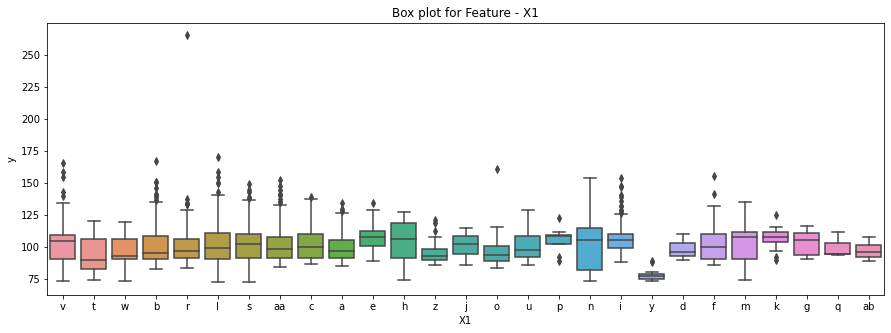

In [35]:
plt.figure(figsize = (15,5))
sb.boxplot(x='X1', y = 'y', data=car_data)
plt.title('Box plot for Feature - X1')
plt.show()

Here we observe that though the all box plots are with in range ~ [75,160] the distributions of population density is not same for all categories.

Here we can observe peculiar case for category 'y' which has values close to 75.

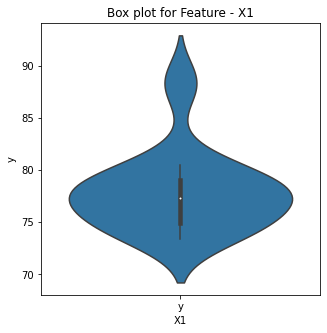

In [36]:
plt.figure(figsize = (5,5))
sb.violinplot(x='X1', y = 'y', data=car_data[car_data['X1']=='y'])
plt.title('Box plot for Feature - X1')
plt.show()

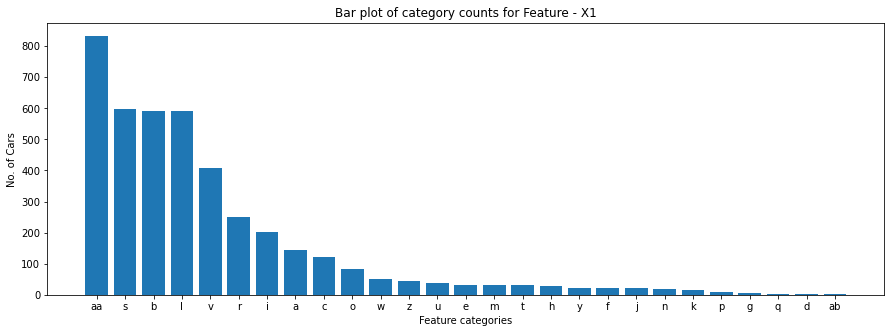

In [37]:
plt.figure(figsize = (15,5))
plt.bar(car_data['X1'].value_counts().index,car_data['X1'].value_counts())
plt.title('Bar plot of category counts for Feature - X1')
plt.xlabel('Feature categories')
plt.ylabel('No. of Cars')
plt.show()

Few categories under this feature are applicable to large population of cars

In [10]:
category_medians =dict()
for cat in car_data['X0'].unique():
    category_medians[cat] = [car_data[car_data['X0']==cat]['y'].describe()['50%']]

#the medians of each category stored in dictionary is converted to dataframe
cat_pd = pd.DataFrame(category_medians)

# median values are sorted
cat_pd = cat_pd.T.sort_values(0)
cat_pd

,0
bc,76.640
az,76.810
ac,89.620
l,89.955
am,89.955
b,90.360
aq,90.370
u,90.730
ad,90.790
e,90.800


In [5]:
# Defining a function to plot medians of y distibution for a given category under selected feature column
def plot_medians(feature):
    '''This function plots the medians of each category under the selected feature'''
    category_medians =dict()
    for cat in car_data[feature].unique():
        category_medians[cat] = [car_data[car_data[feature]==cat]['y'].describe()['50%']]
    
    #the medians of each category stored in dictionary is converted to dataframe
    cat_pd = pd.DataFrame(category_medians)
    
    # median values are sorted
    cat_pd = cat_pd.T.sort_values(0)
    
    # plotting categories vs sorted values
    plt.figure(figsize=(12,4))
    plt.plot(cat_pd.index,cat_pd[0])
    plt.xlabel('Feature category')
    plt.ylabel('Median value of y')
    plt.grid()
    plt.title('Median plot of Feature '+feature)
    plt.show()

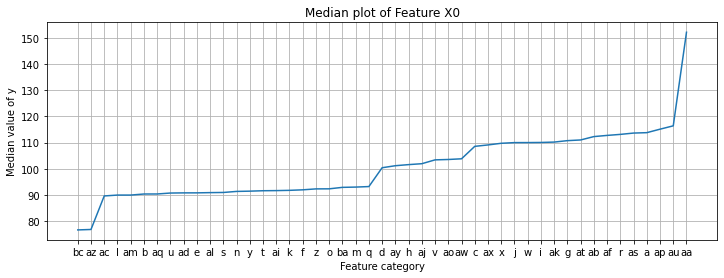

In [6]:
# median plot for feature 'X0'
plot_medians('X0')

From above plots we can see that feature 'X1' will be useful in predicting the target value.

#### Feature X2

Feautre X2 is categorical feature. categories are listed below

In [38]:
car_data['X2'].unique()

array(['at', 'av', 'n', 'e', 'as', 'aq', 'r', 'ai', 'ak', 'm', 'a', 'k',
       'ae', 's', 'f', 'd', 'ag', 'ay', 'ac', 'ap', 'g', 'i', 'aw', 'y',
       'b', 'ao', 'al', 'h', 'x', 'au', 't', 'an', 'z', 'ah', 'p', 'am',
       'j', 'q', 'af', 'l', 'aa', 'c', 'o', 'ar'], dtype=object)

In [39]:
len(car_data['X2'].unique())

44

X2 has 44 unique categories. Categories are set of letters and letter combinations.

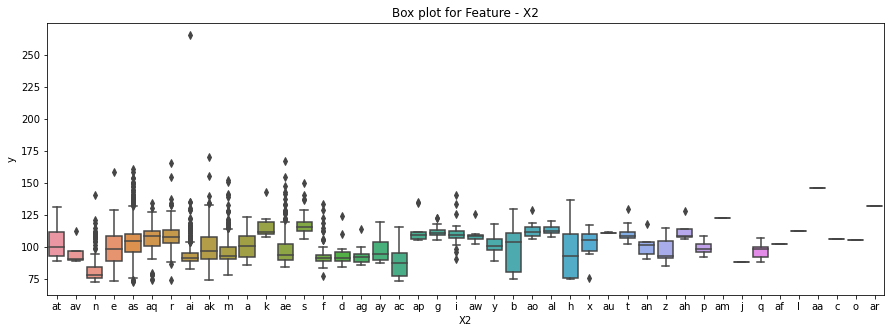

In [40]:
plt.figure(figsize = (15,5))
sb.boxplot(x='X2', y = 'y', data=car_data)
plt.title('Box plot for Feature - X2')
plt.show()

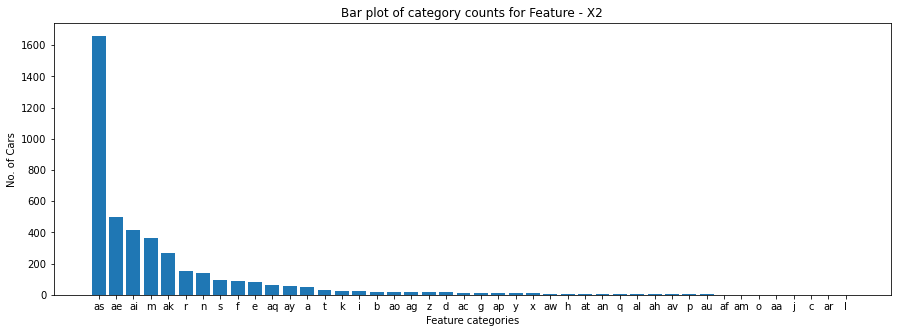

In [41]:
plt.figure(figsize = (15,5))
plt.bar(car_data['X2'].value_counts().index,car_data['X2'].value_counts())
plt.title('Bar plot of category counts for Feature - X2')
plt.xlabel('Feature categories')
plt.ylabel('No. of Cars')
plt.show()

Very few categories are used for majority of cars

feature X2 has distinct distribution of y for its categories. Here also we see lot of outliers. There are few categories which have fixed value(listed below)

In [42]:
car_data[(car_data['X2']=='am') | 
         (car_data['X2']=='j') | 
         (car_data['X2']=='af') |
         (car_data['X2']=='l') | 
         (car_data['X2']=='aa') | 
         (car_data['X2']=='c')| 
         (car_data['X2']=='o')| 
         (car_data['X2']=='ar')][['X2','y']]

,X2,y
1250,am,122.51
1662,j,87.72
2168,af,102.30
2724,l,112.08
3090,aa,146.30
3221,c,105.71
4116,o,105.29
4186,ar,131.98


In [43]:
#category with very few target values
car_data[(car_data['X2']=='au')][['X2','y']]

,X2,y
588,au,111.41
749,au,110.53
2173,au,110.75


Based on the plot feature 'X2' is useful for predicting y value

#### Feature X3

Feautre X3 is categorical feature. categories are listed below

In [44]:
car_data['X3'].unique()

array(['a', 'e', 'c', 'f', 'd', 'b', 'g'], dtype=object)

In [45]:
len(car_data['X3'].unique())

7

X3 has only 7 unique categories. Categories are set of letters

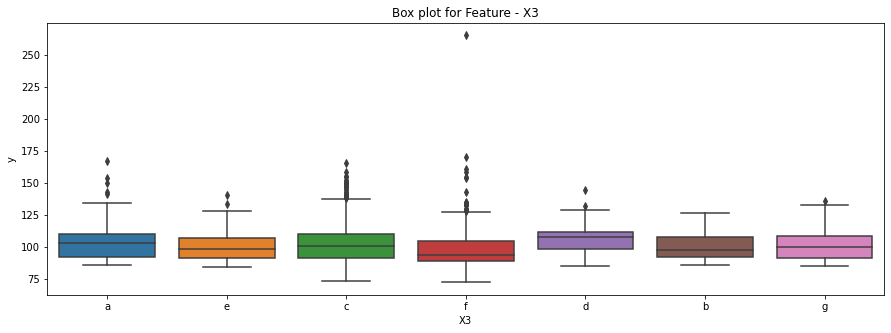

In [46]:
plt.figure(figsize = (15,5))
sb.boxplot(x='X3', y = 'y', data=car_data)
plt.title('Box plot for Feature - X3')
plt.show()

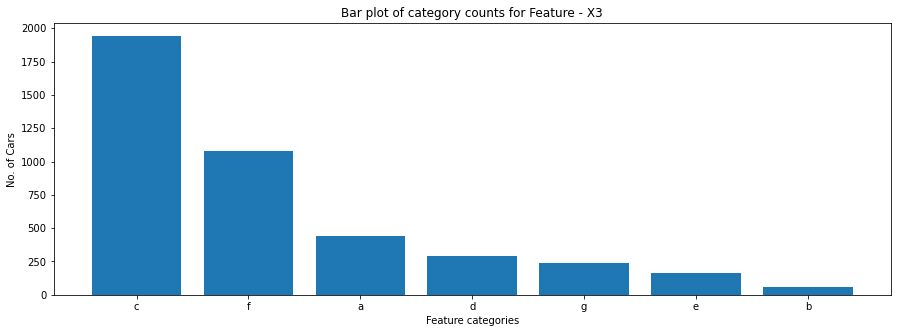

In [47]:
plt.figure(figsize = (15,5))
plt.bar(car_data['X3'].value_counts().index,car_data['X3'].value_counts())
plt.title('Bar plot of category counts for Feature - X3')
plt.xlabel('Feature categories')
plt.ylabel('No. of Cars')
plt.show()

Even though we see 25th and 75th percentile blocks are close by for multiple boxes the 50th percentile line vary. Thus each category have different distributions of y value. This will be a useful feature in predicting value of y

#### Feature X4

Feautre X4 is categorical feature. categories are listed below

In [48]:
car_data['X4'].unique()

array(['d', 'b', 'c', 'a'], dtype=object)

In [49]:
len(car_data['X4'].unique())

4

X4 has only 4 unique categories. Categories are set of letters

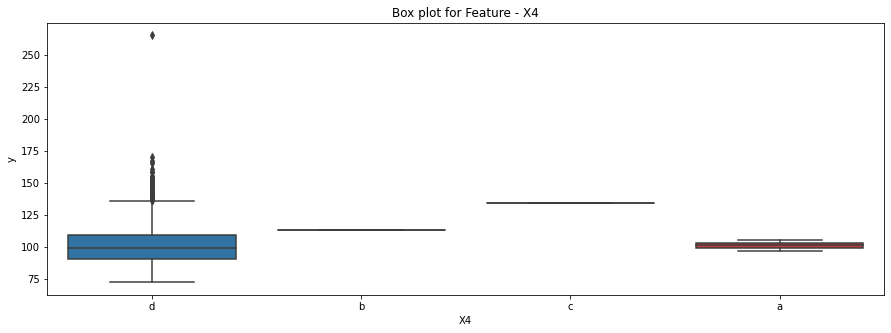

In [50]:
plt.figure(figsize = (15,5))
sb.boxplot(x='X4', y = 'y', data=car_data)
plt.title('Box plot for Feature - X4')
plt.show()

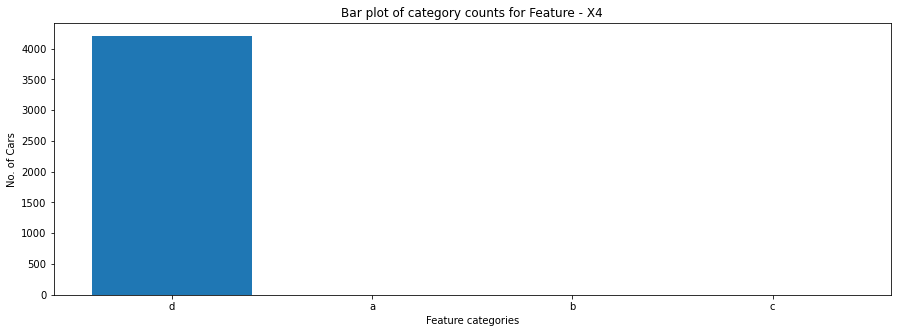

In [51]:
plt.figure(figsize = (15,5))
plt.bar(car_data['X4'].value_counts().index,car_data['X4'].value_counts())
plt.title('Bar plot of category counts for Feature - X4')
plt.xlabel('Feature categories')
plt.ylabel('No. of Cars')
plt.show()

In [52]:
car_data[(car_data['X4']=='a') | 
         (car_data['X4']=='b') |  
         (car_data['X4']=='c')][['X4','y']]

,X4,y
1307,b,112.80
1308,c,134.04
1309,a,96.69
1310,a,105.51


In [53]:
car_data['X4'].value_counts()

d    4205
a       2
b       1
c       1
Name: X4, dtype: int64

In this feature we have only category 'd' for majority of rows (4205 out of 4209). So this feature is pretty constant across rows. 

This feature will not be useful in predicting target value as there is no variation in y with respect to feature X4

#### Feature X5

Feautre X5 is categorical feature. categories are listed below

In [54]:
car_data['X5'].unique()

array(['u', 'y', 'x', 'h', 'g', 'f', 'j', 'i', 'd', 'c', 'af', 'ag', 'ab',
       'ac', 'ad', 'ae', 'ah', 'l', 'k', 'n', 'm', 'p', 'q', 's', 'r',
       'v', 'w', 'o', 'aa'], dtype=object)

In [55]:
len(car_data['X5'].unique())

29

X5 has only 29 unique categories. Categories are set of letters and letter combination

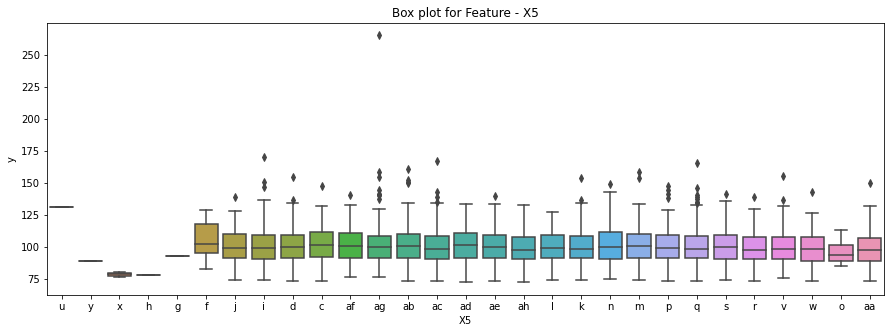

In [56]:
plt.figure(figsize = (15,5))
sb.boxplot(x='X5', y = 'y', data=car_data)
plt.title('Box plot for Feature - X5')
plt.show()

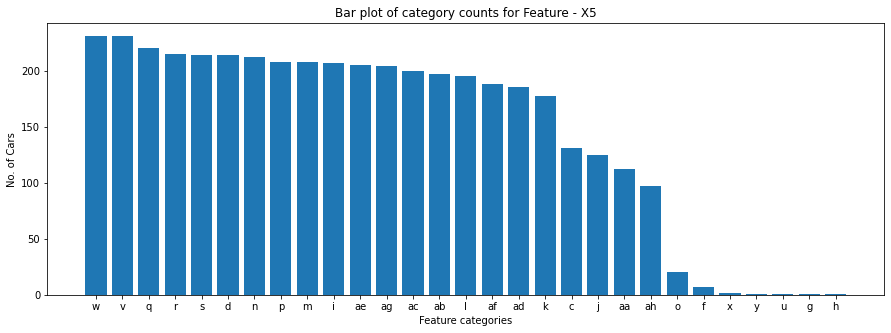

In [57]:
plt.figure(figsize = (15,5))
plt.bar(car_data['X5'].value_counts().index,car_data['X5'].value_counts())
plt.title('Bar plot of category counts for Feature - X5')
plt.xlabel('Feature categories')
plt.ylabel('No. of Cars')
plt.show()

In [58]:
car_data[(car_data['X5']=='u') | 
         (car_data['X5']=='y') |
         (car_data['X5']=='h') |
         (car_data['X5']=='g')][['X5','y']]

,X5,y
0,u,130.81
1,y,88.53
4,h,78.02
5,g,92.93


This feature has distributions which ovelap for many categories except for category o and f,
while categories u,y,h and g has fixed values

Unlike other plots above this has pretty less outliers

### check usefulness

#### Feature X6

Feautre X6 is categorical feature. categories are listed below

In [59]:
car_data['X6'].unique()

array(['j', 'l', 'd', 'h', 'i', 'a', 'g', 'c', 'k', 'e', 'f', 'b'],
      dtype=object)

In [60]:
len(car_data['X6'].unique())

12

X6 has only 12 unique categories. Categories are set of letters

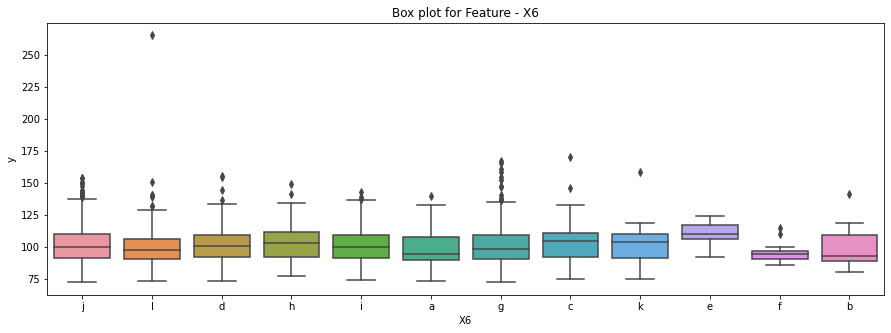

In [61]:
plt.figure(figsize = (15,5))
sb.boxplot(x='X6', y = 'y', data=car_data)
plt.title('Box plot for Feature - X6')
plt.show()

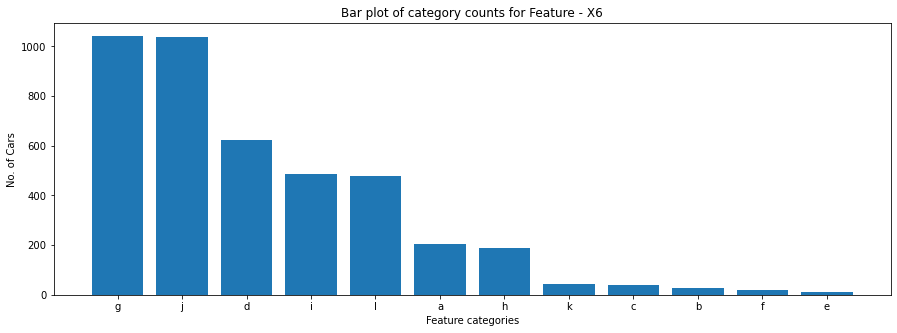

In [62]:
plt.figure(figsize = (15,5))
plt.bar(car_data['X6'].value_counts().index,car_data['X6'].value_counts())
plt.title('Bar plot of category counts for Feature - X6')
plt.xlabel('Feature categories')
plt.ylabel('No. of Cars')
plt.show()

Feature X6 has varying distributions for different categories even though 25th and 75th percentile of the plots are closeby. This feature will be useful in predicting the target value.

#### Feature X8

Feautre X8 is categorical feature. categories are listed below

In [63]:
car_data['X8'].unique()

array(['o', 'x', 'e', 'n', 's', 'a', 'h', 'p', 'm', 'k', 'd', 'i', 'v',
       'j', 'b', 'q', 'w', 'g', 'y', 'l', 'f', 'u', 'r', 't', 'c'],
      dtype=object)

In [64]:
len(car_data['X8'].unique())

25

X8 has only 25 unique categories. Categories are set of letters

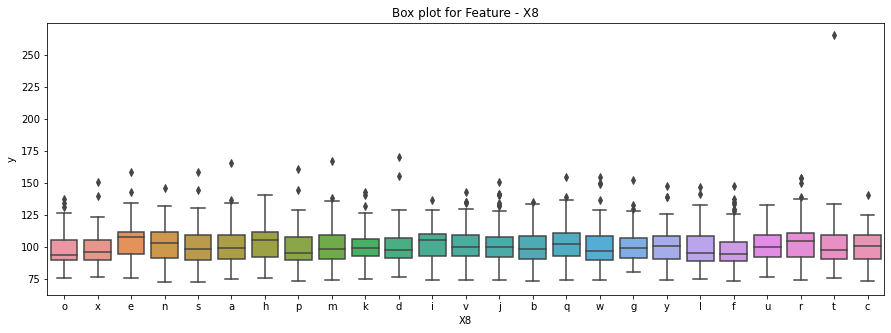

In [65]:
plt.figure(figsize = (15,5))
sb.boxplot(x='X8', y = 'y', data=car_data)
plt.title('Box plot for Feature - X8')
plt.show()

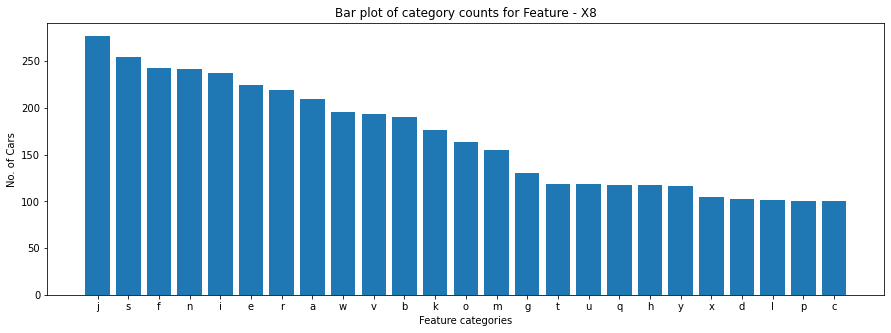

In [66]:
plt.figure(figsize = (15,5))
plt.bar(car_data['X8'].value_counts().index,car_data['X8'].value_counts())
plt.title('Bar plot of category counts for Feature - X8')
plt.xlabel('Feature categories')
plt.ylabel('No. of Cars')
plt.show()

Just like features X3 and X6, X8 has box plots lying in the close range but the distributions are different.
Thus it is useful feature.

Here also we see outliers are lesser

### plot medians

In [67]:
c,m =[],[]
for cat in car_data['X8'].unique():
    c.append(cat)
    m.append(car_data[car_data['X8']==cat]['y'].describe()['50%'])

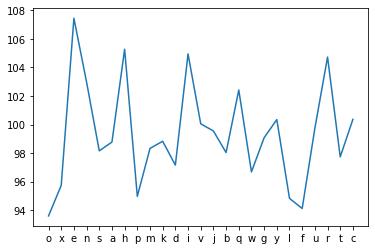

In [68]:
plt.plot(c,m)
plt.show()

#### Feature X10-X385

Features above X8 are all binary features.

Plotting Box plots and bar plots to understand each feature impact on target varibale is cumbersome.

So we can plot Bar features together in single graph, capturing 0 and 1 counts of particular feature.

In [69]:
#value counts of particular feature
car_data[car_data.columns[10:][47]].value_counts()

1    2420
0    1789
Name: X58, dtype: int64

In [70]:
car_data[car_data.columns[10:][47]].value_counts().to_numpy()

array([2420, 1789], dtype=int64)

In [71]:
car_data[car_data.columns[10:][47]].value_counts().sort_index().to_numpy()

array([1789, 2420], dtype=int64)

In [72]:
#For each feature X10 to X385 get the zero and one counts and store in dictionary
feature_dict = dict()
for feat in car_data.columns[10:]:
    counts = car_data[feat].value_counts().sort_index().to_numpy()
    if len(counts)>1:
        feature_dict[feat] = counts

In [73]:
#create data frame of feature counts information
#sort the data along the column direction with respect to row 0
#This helps plotting in order
feature_dict_df = pd.DataFrame(data=feature_dict).sort_values(by = 0 , axis =1)

In [74]:
feature_dict_df

,X205,X74,X111,X361,X229,X128,X120,X263,X136,X61,...,X288,X42,X259,X260,X39,X339,X33,X270,X210,X295
0,1,3,106,143,168,175,178,181,183,194,...,4208,4208,4208,4208,4208,4208,4208,4208,4208,4208
1,4208,4206,4103,4066,4041,4034,4031,4028,4026,4015,...,1,1,1,1,1,1,1,1,1,1


In [75]:
#Store the counts information variables which will be used set the bar lengths for each feature
counts_zeros = feature_dict_df.iloc[0].to_numpy()
counts_ones = feature_dict_df.iloc[1].to_numpy()

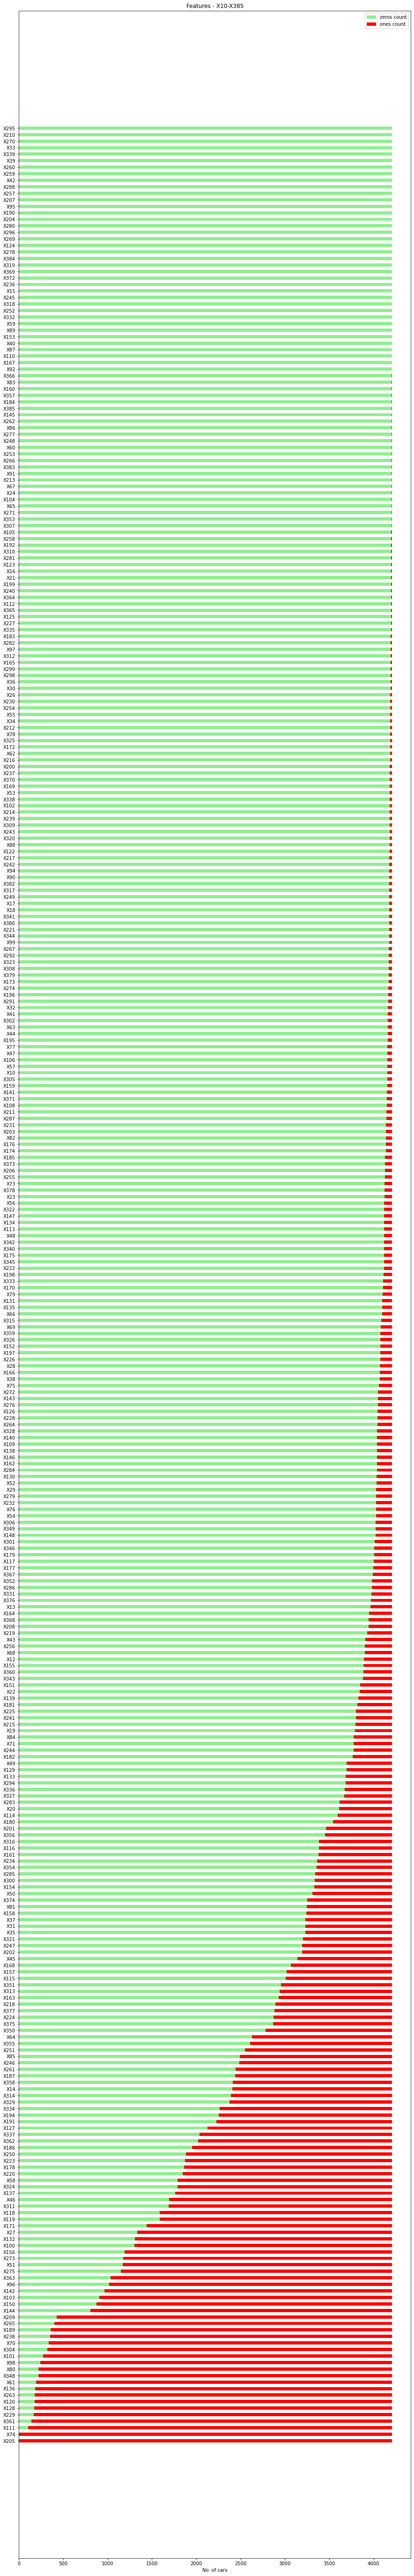

In [76]:
plt.figure(figsize = (15,100))
#horizontal bar to capture zeros count
plt.barh(feature_dict_df.columns,counts_zeros,height = 0.5,color ='lightgreen', label ='zeros count')

#horizontal bar to capture ones count captured right side of the graph.
plt.barh(feature_dict_df.columns,counts_ones,left =counts_zeros, height = 0.5,color ='red', label ='ones count')

plt.yticks(feature_dict_df.columns)
plt.xlabel('No. of cars')
plt.title('Features - X10-X385')
plt.legend()
plt.show()

Here we observe that there lot of features which have majority as zero counts. These features will not useful in predicting target variable as they remain same for majority of rows. We will check the variance of these feature and reject the ones with low value.

#### Duplicate feature check 

We will check for duplicate column using pandas attribute after transposing the dataframe. 

In [77]:
car_data.T[car_data.T.duplicated()]

,0,1,2,3,4,5,6,7,8,9,...,4199,4200,4201,4202,4203,4204,4205,4206,4207,4208
X35,1,1,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
X37,1,1,1,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
X39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X76,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X84,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
X93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X102,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
X107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
X113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


We can see that 56 feature are duplicates. These features can be removed as they can be represented by one similar feature.

### Observations from EDA

- Features ID and X4 can be  it has no impact on the target variable y
- X0,X1,X2,X3,X5,X6 and X8 has impact on y. These features will be Binary encoded.
- We can remove 56 features which are duplicates.
- Features in range X10 to X385 will be filtered by removing features with low variance(<0.0125) and high correlation(<0.9)

### Feature Engineering

#### We will remove features 'ID' and 'X4'

In [78]:
car_data_new_X = car_data.drop(['ID','X4','y'],axis=1)
car_data_new_y = car_data['y']

In [79]:
car_data_new_y

0       130.81
1        88.53
2        76.26
3        80.62
4        78.02
         ...  
4204    107.39
4205    108.77
4206    109.22
4207     87.48
4208    110.85
Name: y, Length: 4209, dtype: float64

#### We will remove the duplicate features

In [80]:
duplicate_feat = car_data_new_X.T[car_data_new_X.T.duplicated()].index.to_numpy()

In [81]:
duplicate_feat,len(duplicate_feat)

(array(['X35', 'X37', 'X39', 'X76', 'X84', 'X93', 'X94', 'X102', 'X107',
        'X113', 'X119', 'X122', 'X134', 'X146', 'X147', 'X172', 'X199',
        'X213', 'X214', 'X216', 'X222', 'X226', 'X227', 'X232', 'X233',
        'X235', 'X239', 'X242', 'X243', 'X244', 'X245', 'X247', 'X248',
        'X253', 'X254', 'X262', 'X266', 'X268', 'X279', 'X289', 'X290',
        'X293', 'X296', 'X297', 'X299', 'X302', 'X320', 'X324', 'X326',
        'X330', 'X347', 'X360', 'X364', 'X365', 'X382', 'X385'],
       dtype=object),
 56)

In [82]:
car_data_new_X = car_data_new_X.drop(duplicate_feat,axis=1)

#### Variance check for Binary value features

In [83]:
# car_data_new_X.iloc[:,7:]

In [84]:
variance_data = car_data_new_X.iloc[:,7:].var()

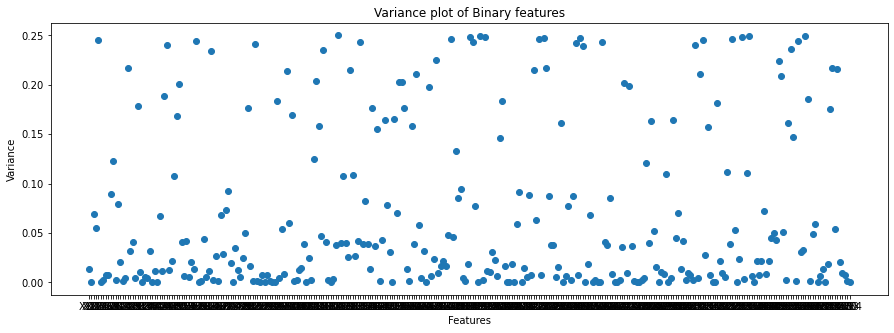

In [85]:
plt.figure(figsize=(15,5))
plt.scatter(variance_data.index,variance_data)
plt.title('Variance plot of Binary features')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.show()

From plot we can observe that there are lot of features which have variance close to zero(the inference we had in bar plot).
We will drop the features which have variance close to zero

Let us consider 5% as threshold for variance and see how is the distribution of 0s and 1s among the feature for the least variance feature.

## Reasoning

In [86]:
variance_data.describe()['max']

0.25003568308721036

In [87]:
Feature_Bi_list = variance_data[variance_data>0.05*variance_data.describe()['max']].index

In [88]:
car_data_new_X[Feature_Bi_list].var().sort_values()

X47     0.012668
X106    0.012900
X10     0.013131
X57     0.013131
X305    0.013131
          ...   
X186    0.248764
X191    0.249212
X362    0.249647
X337    0.249787
X127    0.250036
Length: 194, dtype: float64

In [89]:
car_data_new_X['X47'].value_counts()

0    4155
1      54
Name: X47, dtype: int64

In [90]:
car_data_new_X['X127'].value_counts()

0    2125
1    2084
Name: X127, dtype: int64

So we can make sure that feature category(0/1) with minimum population count is atleast 54.

In [91]:
Feature_Bi_reject = variance_data[variance_data<0.05*variance_data.describe()['max']].index

In [92]:
car_data_new_X = car_data_new_X.drop(Feature_Bi_reject,axis =1)

In [93]:
print('Number of Binary features droped for low variance : ',car_data.iloc[:,10:].shape[1]-car_data_new_X.iloc[:,7:].shape[1])

Number of Binary features droped for low variance :  174


In [94]:
# car_data.iloc[:,10:]
# car_data_new_X.iloc[:,7:]

### Feature Correlation

In [95]:
Correlation_mat = car_data_new_X.corr()

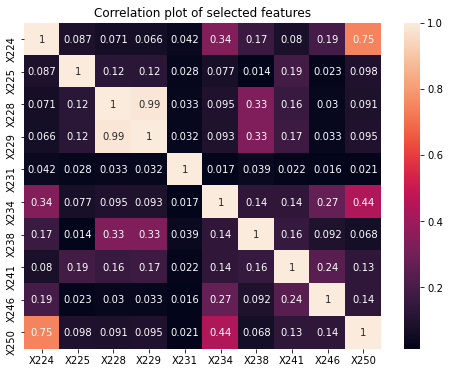

In [96]:
plt.figure(figsize=(8,6))
sb.heatmap(abs(Correlation_mat.iloc[120:130,120:130]),annot=True)
plt.title('Correlation plot of selected features')
plt.show()

We will list out features which have high correlation (>=0.9). For this we need to check only the lower or upper triangle of correlation matrix. For example in the above plot we will consider 'X229' which have 0.99 in the lower triangle and drop it from features list while retaining the feature 'X228'

In [97]:
# plt.figure(figsize=(8,6))
# sb.heatmap(abs(Correlation_mat.iloc[:100,:100]))
# plt.title('Correlation plot of selected features')
# plt.show()

In [98]:
def get_corr_features(corr_mat):
    '''This function returns feature list which have correlation above 0.9 for a given correlation matrix'''
    feature_correlated = []
    for i in range(len(corr_mat)):
        for j in range(i) : #This loop repeat for only till one step before j=i, Thus captures information from
                            #lower triangle matrix. 
            if(corr_mat.iloc[i,j]>=0.9):
                feature_correlated.append(corr_mat.columns[i])
    return feature_correlated

In [99]:
len(get_corr_features(Correlation_mat))

49

In [100]:
feature_correlated = get_corr_features(Correlation_mat)

In [101]:
feature_correlated

['X54',
 'X66',
 'X101',
 'X101',
 'X120',
 'X129',
 'X137',
 'X140',
 'X150',
 'X162',
 'X162',
 'X194',
 'X198',
 'X215',
 'X219',
 'X238',
 'X250',
 'X251',
 'X263',
 'X264',
 'X265',
 'X265',
 'X272',
 'X272',
 'X272',
 'X276',
 'X276',
 'X276',
 'X276',
 'X311',
 'X314',
 'X328',
 'X328',
 'X328',
 'X328',
 'X328',
 'X346',
 'X348',
 'X352',
 'X352',
 'X358',
 'X362',
 'X363',
 'X367',
 'X367',
 'X367',
 'X368',
 'X371',
 'X378']

##### 49 features having correlation above 0.9 will be removed

In [102]:
car_data_new_X = car_data_new_X.drop(feature_correlated,axis=1) 

In [103]:
print('Number of features size after : ',car_data_new_X.shape)

Number of features size after :  (4209, 167)


In [104]:
car_data.shape

(4209, 378)

In [105]:
car_data_new_X

,X0,X1,X2,X3,X5,X6,X8,X10,X12,X13,...,X354,X355,X356,X359,X361,X373,X374,X375,X376,X377
0,k,v,at,a,u,j,o,0,0,1,...,1,0,0,0,1,0,0,0,0,1
1,k,t,av,e,y,l,o,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,az,w,n,c,x,j,x,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,az,t,n,f,x,l,e,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,az,v,n,f,h,d,n,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,aa,d,q,0,0,0,...,1,0,0,0,1,0,0,1,0,0
4205,j,o,t,d,aa,h,h,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4206,ak,v,r,a,aa,g,e,0,1,1,...,1,0,0,0,1,0,0,0,0,1
4207,al,r,e,f,aa,l,u,0,0,0,...,0,0,0,0,1,0,1,0,0,0


### Forward Feature Filtering


#### Down select Binary features based on its impact on R^2 score of a random forest regressor model.

In [106]:
# Forward filtering is based on randomforest regressor r2 score 
# Ref https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/36390

In [108]:
# Creating Feature list of Binary features 
feat_set = list(car_data_new_X.iloc[:,7:].columns)
feat_count = len(feat_set)
feat_wts_dict = dict()

# Weight Threshold for feature selection
feat_wt_threshold = 0.1

# Initially assign uniform weights to each feature
for feat in feat_set:
    feat_wts_dict[feat] = 1/feat_count

scores = list()    
best_features = list()   

# increment factor to be added to weights when they improve the validation scores of the model
# if there is no improvement, the weight is reduced by same factor
feat_factor = 0.2

epochs = 200

for i in tqdm(range(epochs)):

    # Random feature selection based on their weights and without replacement
    random_feat = np.random.choice(feat_set, size=10, replace=False, p = list(feat_wts_dict.values()))    
    #print('after selection ',len(random_feat))
     
    # Random forest regressor model definition
    X = car_data[random_feat]
    y = car_data['y']
    rf_clf = RandomForestRegressor(n_estimators=100,
                                   criterion='mse',
                                   max_depth=10,
                                   min_samples_split=5)
    
    # K fold Cross validation of the model
    score = np.mean(cross_val_score(rf_clf, X,y,cv = 3, scoring='r2',n_jobs=-1))
    scores.append(score)
    #print('features :', random_feat)
    #print('score :', score) 
    
    # Increasing / Decreasing weightage based on results of cross validation
    if (i>24):
        if score>np.mean(scores[-25:]):
            for feat in random_feat:
                feat_wts_dict[feat] *= (1+feat_factor)
        
        else:
            for feat in random_feat:
                feat_wts_dict[feat] *= (1-feat_factor)
        
        # normalize feature weights after modifying the feature weights based on scoring 
        wt_sum = sum(feat_wts_dict.values())
        for feat in feat_set:
            feat_wts_dict[feat] /= wt_sum
                
        
    #print('feat size',len(feat_wts_dict))
    
    # Adding feature to Best feature list
    if max(feat_wts_dict.values())> feat_wt_threshold:
        #print('max wt',max(feat_wts_dict.values()))
        
        # list of features which has weights more than threshold are considered best features
        for feat in feat_set:
            if feat_wts_dict[feat] > feat_wt_threshold:
#                 print(feat)
                #adding feature to best feature list
                best_features.append(feat)
    
                # remove best features from feat_set and corresponding weights for next iteration
                feat_set.remove(feat)
                del feat_wts_dict[feat]
                
        #print('epoch', i)
        #print(best_features)
        
        # update feature weights after removing the best features from feature set
        wt_sum = sum(feat_wts_dict.values())
        for feat in feat_set:
            feat_wts_dict[feat] /= wt_sum
        
    if (len(best_features)>99):
        print('100 features are selected as Best Features \n Feature Selection loop terminated...')
        break

print('Number of features selected after %d epochs are : %d' %(epochs,len(best_features)))

 12%|██████████▏                                                                      | 25/200 [00:16<01:58,  1.47it/s]


KeyboardInterrupt: 

In [ ]:
len(scores)

In [ ]:
max(feat_wts_dict.values())

In [ ]:
len(best_features)

In [ ]:
best_features

In [ ]:
t = list(feat_wts_dict.values())

In [ ]:
t.sort()

In [ ]:
t[-20:]

In [ ]:
rf_clf.fit(car_data[best_features],car_data['y'])

In [ ]:
rf_clf.feature_importances_

In [ ]:
feat_imp = pd.Series(rf_clf.feature_importances_ ,index = best_features).sort_values()

In [ ]:
feat_imp.plot.bar()
plt.show()

In [ ]:
sum(feat_imp)#.iloc[-20:]

In [ ]:
score = np.mean(cross_val_score(rf_clf,car_data[best_features],car_data['y'],cv = 3, scoring='r2'))
score

In [ ]:
r2_score(car_data['y'], rf_clf.predict(car_data[best_features]))

#### Combining the categorical features with selected best features

In [ ]:
car_data_new_X = pd.concat([car_data_new_X.iloc[:,0:6],car_data_new_X[best_features],axis=1)
car_data_new_X.head()

#### Binary encoding of categorical features to feed into the ML model.

In [108]:
import category_encoders as ce

In [50]:
Bi_encoder_X0 = ce.BinaryEncoder(drop_invariant=True)
Bi_encoder_X1 = ce.BinaryEncoder(drop_invariant=True)
Bi_encoder_X2 = ce.BinaryEncoder(drop_invariant=True)
Bi_encoder_X3 = ce.BinaryEncoder(drop_invariant=True)
Bi_encoder_X4 = ce.BinaryEncoder(drop_invariant=True)
Bi_encoder_X5 = ce.BinaryEncoder(drop_invariant=True)
Bi_encoder_X6 = ce.BinaryEncoder(drop_invariant=True)
Bi_encoder_X8 = ce.BinaryEncoder(drop_invariant=True)

Fit and transform of features X0,X1,X2,X3,X4,X5,X6 and X8

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
#Droping ID, X4 and y columns from feature data for further processing. y calues captured in another data frame.
car_data_new_X = car_data.drop(['ID','X4','y'],axis=1)
car_data_new_y = car_data['y']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(car_data_new_X, 
                                                    car_data_new_y, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [59]:
Bi_encoder_X0.fit_transform(X_train['X0'])

,X0_0,X0_1,X0_2,X0_3,X0_4,X0_5,X0_6
1402,0,0,0,0,0,0,1
3919,0,0,0,0,0,1,0
3349,0,0,0,0,0,1,1
174,0,0,0,0,1,0,0
393,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...
3444,0,0,0,0,0,0,1
466,0,0,1,0,1,1,0
3092,0,0,0,1,0,1,1
3772,0,0,0,1,0,1,1


In [110]:
X0_bi = Bi_encoder_X0.fit_transform(car_data['X0'])
X1_bi = Bi_encoder_X1.fit_transform(car_data['X1'])
X2_bi = Bi_encoder_X2.fit_transform(car_data['X2'])
X3_bi = Bi_encoder_X3.fit_transform(car_data['X3'])
# feature X4 is not considered. Refer EDA section
X5_bi = Bi_encoder_X5.fit_transform(car_data['X5'])
X6_bi = Bi_encoder_X6.fit_transform(car_data['X6'])
X8_bi = Bi_encoder_X8.fit_transform(car_data['X8'])

In [111]:
car_data_new_enc_X = pd.concat([X0_bi,X1_bi,X2_bi,X3_bi,X5_bi,X6_bi,X8_bi,car_data_new_X.iloc[:,7:]],axis=1)
car_data_new_enc_X.iloc[:,:20].head()

,X0_1,X0_2,X0_3,X0_4,X0_5,X0_6,X1_1,X1_2,X1_3,X1_4,X1_5,X2_1,X2_2,X2_3,X2_4,X2_5,X2_6,X3_1,X3_2,X3_3
0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,1,1
3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0


#### LOF

In [112]:
from sklearn.neighbors import LocalOutlierFactor

In [200]:
LOF_clf = LocalOutlierFactor(n_neighbors=10)

In [201]:
LOF_clf.fit_predict(car_data_new_enc_X,car_data['y'])

array([ 1,  1, -1, ...,  1,  1,  1])

In [202]:
max(abs(LOF_clf.negative_outlier_factor_))

3.253972898502821

In [203]:
# del outlier_car

In [204]:
outlier_car = dict()
for i in range(len(car_data)):
    if abs(LOF_clf.negative_outlier_factor_[i])>1.5:
        outlier_car[i] = abs(LOF_clf.negative_outlier_factor_[i])

In [205]:
outlier_car.keys()

dict_keys([2, 3, 37, 50, 81, 85, 117, 143, 161, 173, 179, 190, 216, 239, 299, 327, 350, 381, 424, 440, 455, 459, 499, 510, 523, 534, 582, 588, 620, 676, 678, 726, 768, 795, 811, 864, 872, 892, 910, 913, 1039, 1049, 1060, 1070, 1096, 1108, 1143, 1160, 1169, 1206, 1253, 1266, 1279, 1345, 1356, 1362, 1370, 1379, 1388, 1414, 1415, 1430, 1451, 1465, 1466, 1469, 1588, 1599, 1603, 1639, 1662, 1709, 1732, 1733, 1740, 1769, 1770, 1771, 1828, 1853, 1866, 1888, 1931, 1957, 1965, 1983, 1992, 2002, 2068, 2093, 2108, 2148, 2165, 2173, 2188, 2195, 2236, 2239, 2268, 2276, 2292, 2300, 2312, 2320, 2352, 2553, 2574, 2603, 2613, 2630, 2661, 2724, 2742, 2835, 2908, 3006, 3041, 3089, 3090, 3142, 3150, 3185, 3199, 3221, 3232, 3239, 3294, 3340, 3392, 3424, 3464, 3492, 3507, 3510, 3539, 3546, 3553, 3601, 3610, 3627, 3632, 3668, 3745, 3920, 3936, 3960, 4005, 4038, 4082, 4090, 4106, 4111, 4121, 4131, 4185, 4196, 4202])

In [206]:
len(outlier_car)

157

In [122]:
test = np.array(list(outlier_car.values()))

In [123]:
test.sort()

In [124]:
test

array([1.50139252, 1.50490882, 1.50603673, 1.5071732 , 1.50885966,
       1.51408485, 1.51462191, 1.51665459, 1.52059877, 1.52081619,
       1.52360493, 1.52811004, 1.52812265, 1.52861231, 1.53146172,
       1.53346601, 1.53920973, 1.54255624, 1.54344524, 1.54509598,
       1.54626306, 1.54788268, 1.55082437, 1.55091483, 1.55429242,
       1.55862278, 1.5649115 , 1.57177745, 1.57689418, 1.58220085,
       1.58908513, 1.59164949, 1.59652025, 1.59691479, 1.59698658,
       1.59852812, 1.603159  , 1.60594584, 1.60765211, 1.60871266,
       1.61556217, 1.61959868, 1.62119981, 1.62625603, 1.62879657,
       1.63051284, 1.63071136, 1.6327728 , 1.63955708, 1.64294497,
       1.6600767 , 1.66722574, 1.66971335, 1.68294344, 1.69773796,
       1.69837122, 1.71277141, 1.71452909, 1.72446646, 1.73065491,
       1.73805147, 1.75811387, 1.75920807, 1.77018824, 1.79451932,
       1.80259647, 1.82974367, 1.84570731, 1.85465913, 1.86513263,
       1.86705556, 1.87427328, 1.87586174, 1.87950357, 1.88611

#### Dimensionality reduction

In [249]:
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection

#### PCA

In [407]:
car_data_new_enc_X.shape

(4209, 194)

In [408]:
pca = PCA(n_components = 15)
car_data_pca = pca.fit_transform(car_data_new_enc_X)

In [409]:
sum(pca.explained_variance_ratio_)

0.5764140420944908

In [410]:
car_data_pca[0]

array([ 1.06226554, -0.29680824,  1.83340597,  0.0299167 ,  1.43840107,
        0.08642852, -0.05405809, -0.95002891, -0.37474525,  0.49891164,
       -0.11926101,  0.5984676 ,  0.44265162,  0.23546918, -0.48053393])

In [411]:
dim_redn_feat_1 = pd.DataFrame(car_data_pca,columns=np.arange(15))

#### truncated SVD

In [412]:
tSVD = TruncatedSVD(n_components = 15)
car_data_tsvd = tSVD.fit_transform(car_data_new_enc_X)

In [413]:
sum(tSVD.explained_variance_ratio_)

0.5655477417732174

In [414]:
car_data_tsvd[0]

array([ 3.67029418,  0.89946857, -0.722535  ,  1.74543102,  0.64665253,
        0.61333799,  0.19615381, -0.20443169, -0.82300763, -0.20724446,
        0.53318952,  0.08407329,  0.48736906,  0.39294039, -0.13212842])

In [415]:
car_data_tsvd.shape

(4209, 15)

In [416]:
dim_redn_feat_2 = pd.DataFrame(car_data_tsvd,columns=np.arange(15)+15)

#### ICA

In [417]:
F_ica = FastICA(n_components = 15)
car_data_fica = F_ica.fit_transform(car_data_new_enc_X)
dim_redn_feat_3 = pd.DataFrame(car_data_fica,columns=np.arange(15)+15*2)

In [418]:
gaussian_feat = GaussianRandomProjection(n_components = 15)
car_data_gaussian = gaussian_feat.fit_transform(car_data_new_enc_X)
dim_redn_feat_4 = pd.DataFrame(car_data_gaussian,columns=np.arange(15)+15*3)

In [419]:
sparse_feat = SparseRandomProjection(n_components = 15)
car_data_sparse = sparse_feat.fit_transform(car_data_new_enc_X)
dim_redn_feat_5 = pd.DataFrame(car_data_sparse,columns=np.arange(15)+15*4)

In [420]:
dim_redn_feat = pd.concat([dim_redn_feat_1,
                           dim_redn_feat_2,
                           dim_redn_feat_3,
                           dim_redn_feat_4,
                           dim_redn_feat_5],axis=1)

In [424]:
dim_redn_feat.shape

(4209, 75)

In [423]:
get_corr_features(dim_redn_feat.corr())

[16, 17, 18, 19, 23, 24, 25, 26, 27, 28]

#### 2 and 3 way interaction

In [374]:
# https://medium.com/analytics-vidhya/detailed-solution-to-mercedes-benz-green-manufacturing-competition-on-kaggle-7b85c84a3ff5

In [388]:
# car_data_bi_ft = car_data_new_X.iloc[:,10:]
car_data_bi_ft = car_data_new_X.iloc[:,7:]

In [393]:
Binary_ft = car_data_bi_ft.columns

In [389]:
from itertools import combinations

In [394]:
two_feat_combi = list(combinations(Binary_ft,2))
three_feat_combi = list(combinations(Binary_ft,3))

In [395]:
len(two_feat_combi),len(three_feat_combi)

(12720, 669920)

In [396]:
two_ft = dict()
for i,j in tqdm(two_feat_combi):
    two_ft_corr = (car_data_bi_ft[i]+car_data_bi_ft[j]).corr(car_data['y'])
    if(two_ft_corr>0.65):
        two_ft[i+'_'+j] = two_ft_corr

100%|██████████████████████████████████████████████████████████████████████████| 12720/12720 [00:06<00:00, 2098.15it/s]


In [397]:
two_ft

{}

In [400]:
three_ft = dict()
for i,j,k in tqdm(three_feat_combi):
    three_ft_corr = (car_data_bi_ft[i]+car_data_bi_ft[j]+car_data_bi_ft[k]).corr(car_data['y'])
    if(three_ft_corr>0.65):
        three_ft[i+'_'+j+'_'+k] = three_ft_corr

100%|████████████████████████████████████████████████████████████████████████| 669920/669920 [07:40<00:00, 1455.86it/s]


In [401]:
three_ft

{'X47_X136_X261': 0.6528948987521473,
 'X126_X136_X261': 0.6600700694728542,
 'X126_X261_X315': 0.6525453966165529,
 'X130_X136_X261': 0.6559414232668606,
 'X130_X261_X315': 0.6578548518702719,
 'X136_X179_X261': 0.6628575336567439,
 'X136_X255_X261': 0.6531250075523546,
 'X136_X261_X315': 0.6949879115351711,
 'X179_X261_X315': 0.6552476867575522}

### Feature combinations

#### Binary encoded categorical Feature + Filtered Features

#### Binary encoded categorical Feature + Filtered Features + 2/3 wayfeature interaction

#### Dimensionality Reduction features

#### Dimensionality Reduction features + 2/3 way feature interaction

### Train Test Split

### Model Definition

### Model 1

### Model 2

### Model 3

### Results